<a href="https://www.kaggle.com/code/hwanchul/lending-club-prep?scriptVersionId=262369844" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 데이터 불러오기

In [1]:
import kagglehub
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

# Download latest version
path = kagglehub.dataset_download("wordsforthewise/lending-club")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df1 = pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv', low_memory=False)
#df2 = pd.read_csv('/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv', low_memory=False)

print("--- df1's info ---")
df1.info()

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv
--- df1's info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


## 프로젝트 목표 
___
- 대출자의 부도 예측: 대출 상환에 실패할 (Default) 대출자를 사전에 예측하는 분류(Classification) 문제.

- 타겟 변수 정의
    - loan_status를 활용하여 label 변수 생성
    
        - 부도(Default) 그룹: Charged Off, Default, Late (31-120 days)
    
        - 정상(Non-Default) 그룹: Fully Paid, Current
    
        - In Grace Period는 아직 부도로 확정되지 않은 상태이므로, 분석 목적에 따라 정상 그룹에 포함하거나 제외할 수 있습니다.

## 컬럼별 정보 (업데이트 예정)

### accepted_2007_to_2018Q4
___
대출이 승인된 기록과 대출 상환에 대한 정보

- id / member_id: 대출의 고유 식별자입니다.

- loan_amnt: 신청된 대출 금액입니다.

- funded_amnt: 승인된 대출 금액입니다.

- funded_amnt_inv: 투자자들에게 실제 자금이 조달된 금액입니다.

- term: 대출 상환 기간 (예: 36개월, 60개월)입니다.

- int_rate: 대출 금리(이자율)입니다.

- installment: 매월 상환해야 하는 원리금(원금 + 이자)입니다.

- grade / sub_grade: Lending Club이 자체적으로 평가한 신용 등급입니다. (예: A, B, C / A1, A2...)

- emp_title: 대출 신청자의 직업입니다.

- emp_length: 현재 직장에서의 근무 기간입니다.

- home_ownership: 대출 신청자의 주거 형태입니다. (예: 임대, 자가 소유, 모기지)

- annual_inc: 연간 소득입니다.

- verification_status: 소득 정보의 인증 여부입니다.

- issue_d: 대출이 승인된 날짜입니다.

- loan_status: 가장 중요한 컬럼 중 하나로, 대출의 현재 상태를 나타냅니다. (예: Fully Paid - 전액 상환, Charged Off - 부도 처리)

- purpose: 대출 목적입니다. (예: 신용카드 부채 통합, 주택 개조, 사업 자금)

- title: 대출자가 직접 기입한 대출 제목입니다.

- addr_state: 대출 신청자의 주(State)입니다.

- dti: 부채-소득 비율(Debt-to-Income Ratio)입니다. 월간 부채 상환액이 월 소득에서 차지하는 비율을 나타냅니다.

- delinq_2yrs: 지난 2년간 30일 이상 연체된 횟수입니다.

- pub_rec: 공공 기록에 남은 연체(부도) 횟수입니다.

- revol_bal: 회전식 신용 잔고(Revolving balance)입니다. 신용카드를 사용하고 갚지 않은 잔액을 의미합니다.

- total_acc: 총 신용 계좌(신용카드, 대출)의 개수입니다.

- earliest_cr_line: 신용 거래 시작일입니다.

- mort_acc: 모기지 계좌의 개수입니다.

- pub_rec_bankruptcies: 공공 기록에 남은 파산 횟수입니다.

- tax_liens: 세금 유치권(체납) 개수입니다.

- tot_cur_bal: 모든 계좌의 총 현재 잔액입니다.

### rejected_2007_to_2018Q4
___

대출이 거절된 기록

- Amount Requested: 신청된 대출 금액입니다.

- Application Date: 대출 신청일입니다.

- Loan Title: 대출 목적입니다.

- Risk_Score: Lending Club이 산정한 자체 리스크 점수입니다. 점수가 높을수록 리스크가 낮습니다.

- Debt-To-Income Ratio: 부채-소득 비율입니다.

- State: 신청자의 주(State)입니다.

- Employment Length: 현재 직장에서의 근무 기간입니다.

- Policy Code: 대출 정책 코드입니다.

# 분석데이터 만들기

## 데이터 필터링
___

In [2]:
# 대출승인날짜(issue_d)를 토대로 대출승인 년도(issue_year), 월(issue_month), 분기(issue_quarter) 정보 추출

df1.dropna(subset=['issue_d'], inplace=True) ## issue_d 결측 데이터 삭제 --> 33개

df1['issue_month'] = df1['issue_d'].str.split('-', expand=True)[0]
df1['issue_year'] = df1['issue_d'].str.split('-', expand=True)[1].astype(int)

def get_quarter(month):
    if month in ['Jan', 'Feb', 'Mar']:
        return 'Q1'
    elif month in ['Apr', 'May', 'Jun']:
        return 'Q2'
    elif month in ['Jul', 'Aug', 'Sep']:
        return 'Q3'
    else:
        return 'Q4'

df1['issue_quarter'] = df1['issue_month'].apply(get_quarter)

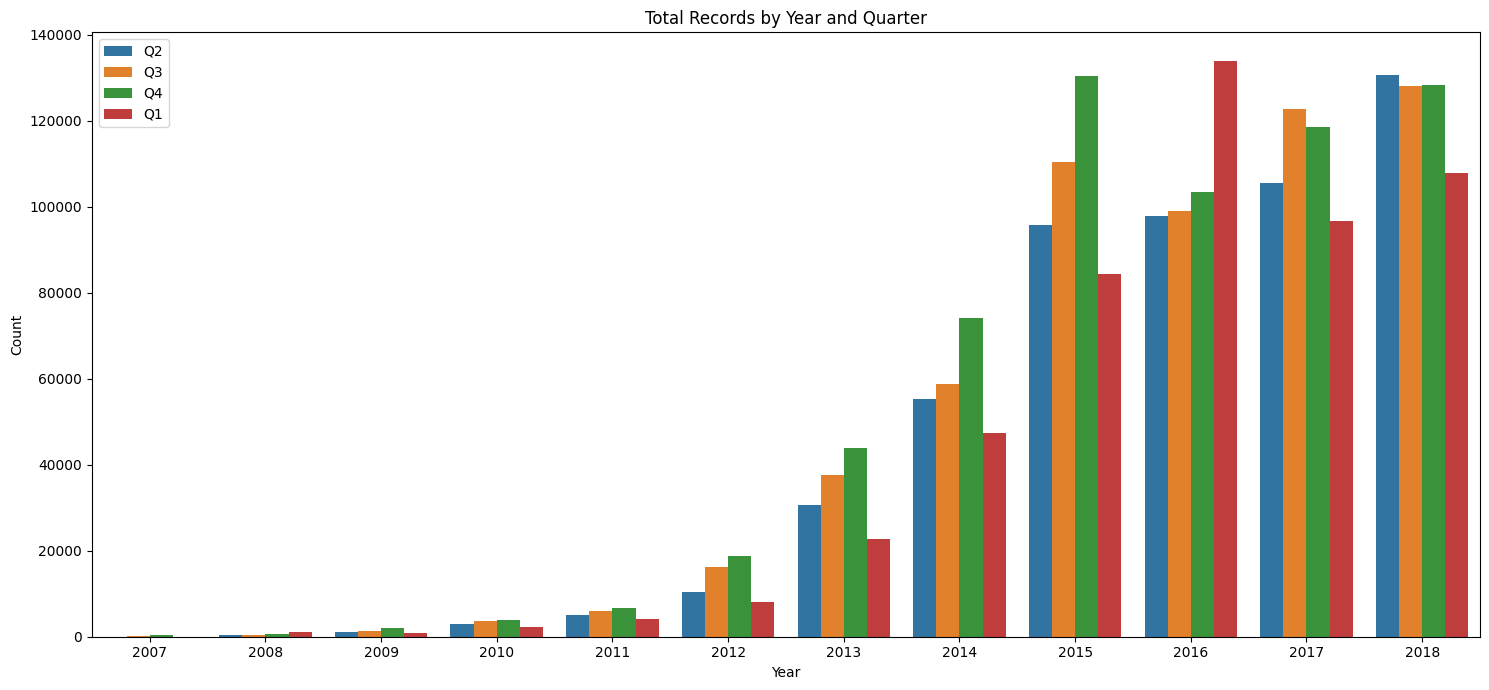

In [3]:
# 연도별 총 레코드 수 계산
total_records_by_year = df1['issue_year'].value_counts().sort_index()

# 연도-분기별 총 레코드 수
total_records_by_quater = df1.groupby(['issue_year', 'issue_quarter'])['issue_d'].count().sort_index()
total_records_by_quater.name = 'count'

# 연도-분기별 총 레코드 수 시각화
plt.figure(figsize=(15, 7))

sns.barplot(x='issue_year', y='count', hue='issue_quarter', data=total_records_by_quater.reset_index())
plt.title('Total Records by Year and Quarter')
plt.xlabel('Year'); plt.ylabel('Count')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

데이터 필터링 기준 및 이유
___
분석데이터를 `2015`년 이후 데이터만 활용 후 추후 확장 고려

In [4]:
#df1 = df1[df1['issue_year'] == 2015]
df1 = df1[df1['issue_year'] == 2015]
df1

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,issue_month,issue_year,issue_quarter
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,N,NaN,NaN,NaN,NaN,NaN,NaN,Dec,2015,Q4
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,N,NaN,NaN,NaN,NaN,NaN,NaN,Dec,2015,Q4
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,N,NaN,NaN,NaN,NaN,NaN,NaN,Dec,2015,Q4
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,N,NaN,NaN,NaN,NaN,NaN,NaN,Dec,2015,Q4
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,N,NaN,NaN,NaN,NaN,NaN,NaN,Dec,2015,Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421090,36371250,NaN,10000.0,10000.0,10000.0,36 months,11.99,332.10,B,B5,...,N,NaN,NaN,NaN,NaN,NaN,NaN,Jan,2015,Q1
421091,36441262,NaN,24000.0,24000.0,24000.0,36 months,11.99,797.03,B,B5,...,N,NaN,NaN,NaN,NaN,NaN,NaN,Jan,2015,Q1
421092,36271333,NaN,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,D2,...,N,NaN,NaN,NaN,NaN,NaN,NaN,Jan,2015,Q1
421093,36490806,NaN,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,E3,...,N,NaN,NaN,NaN,NaN,NaN,NaN,Jan,2015,Q1


## 타겟 변수 정의
___


`loan_status`를 활용하여 `is_default` 변수 생성

- 부도(Default) 그룹: Charged Off, Default, Late (31-120 days)

- 정상(Non-Default) 그룹: Fully Paid, Current

- In Grace Period는 아직 부도로 확정되지 않은 상태이므로, 분석에서 제외하였음


대출 상태(loan_status) 값별 의미
___
NonDefault Group
- Fully Paid: 대출자가 모든 원금과 이자를 전액 상환하여 대출 계약이 완료된 상태입니다. 이는 대출 상환에 성공한 사례로 분류됩니다.

- Current: 대출자가 현재 상환 기한을 잘 지키고 있는 상태입니다. 이 대출들은 아직 계약이 끝나지 않았으며, 현재로서는 부도 위험이 없는 것으로 간주됩니다.

Default Group
- Charged Off: 대출 상환이 불가능하다고 판단되어 부도 처리된 상태입니다. 이는 회수 가능성이 낮아 손실로 기록된 경우입니다. 모델링에서는 주로 이 값을 '부도(Default)'로 정의합니다.

- Late (31-120 days): 대출 상환일로부터 31일에서 120일 사이로 연체된 상태입니다.

- Late (16-30 days): 상환일로부터 16일에서 30일 사이로 연체된 상태입니다.

- Default: 대출 상환 의무를 이행하지 못해 부도 상태에 빠진 경우입니다. Charged Off와 유사하지만, Lending Club의 내부 정책에 따라 부도 처리 전 단계로 분류될 수 있습니다.

Else
- In Grace Period: 상환일로부터 15일의 유예 기간 내에 있는 상태입니다. 이 기간에는 연체로 간주되지 않습니다.

In [5]:
df1['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default'], dtype=object)

In [6]:
def create_label(x):
    if x in ['Fully Paid', 'Current']:
        return 'NonDefault'
    elif x in ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default']:
        return 'Default'
    return None 

In [7]:
df1['is_default'] = df1['loan_status'].apply(create_label)
df1 = df1.dropna(subset=['is_default'])
#df1.to_csv('accepted_2015.csv', index=False)

## 결측치 처리
___

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_missing_counts_by_columns(df):
    '''
    컬럼별 결측치 숫자 및 비율 시각화 및 반환 함수
    '''

    # 컬럼별 결측치 숫자 및 비율 정보 추출
    tmp = df.isnull().sum() 
    tmp_ratio = (tmp / len(df)) * 100
    missing_info = pd.DataFrame({'Missing_Count': tmp, 'Missing_Ratio': tmp_ratio})
    missing_info = missing_info[missing_info['Missing_Count'] != 0].sort_values(by='Missing_Count')
    
    # 시각화 
    height = 5 + len(missing_info) // 10
    
    plt.figure(figsize=(20, height))
    ax = missing_info['Missing_Count'].plot(kind='barh')
    
    for p in ax.patches:
        ax.annotate(str(int(p.get_width())), (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                    ha='left', va='center')
                    
    plt.title('Column Missing Values')
    plt.xlabel('Number of Missing Values')
    plt.ylabel('Columns')
    plt.tight_layout()
    plt.show()

    return missing_info

In [9]:
# 불필요한 특징 제거
df1 = df1.drop(['member_id', 'desc', 'url'], axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420483 entries, 0 to 421094
Columns: 152 entries, id to is_default
dtypes: float64(112), int64(1), object(39)
memory usage: 490.8+ MB


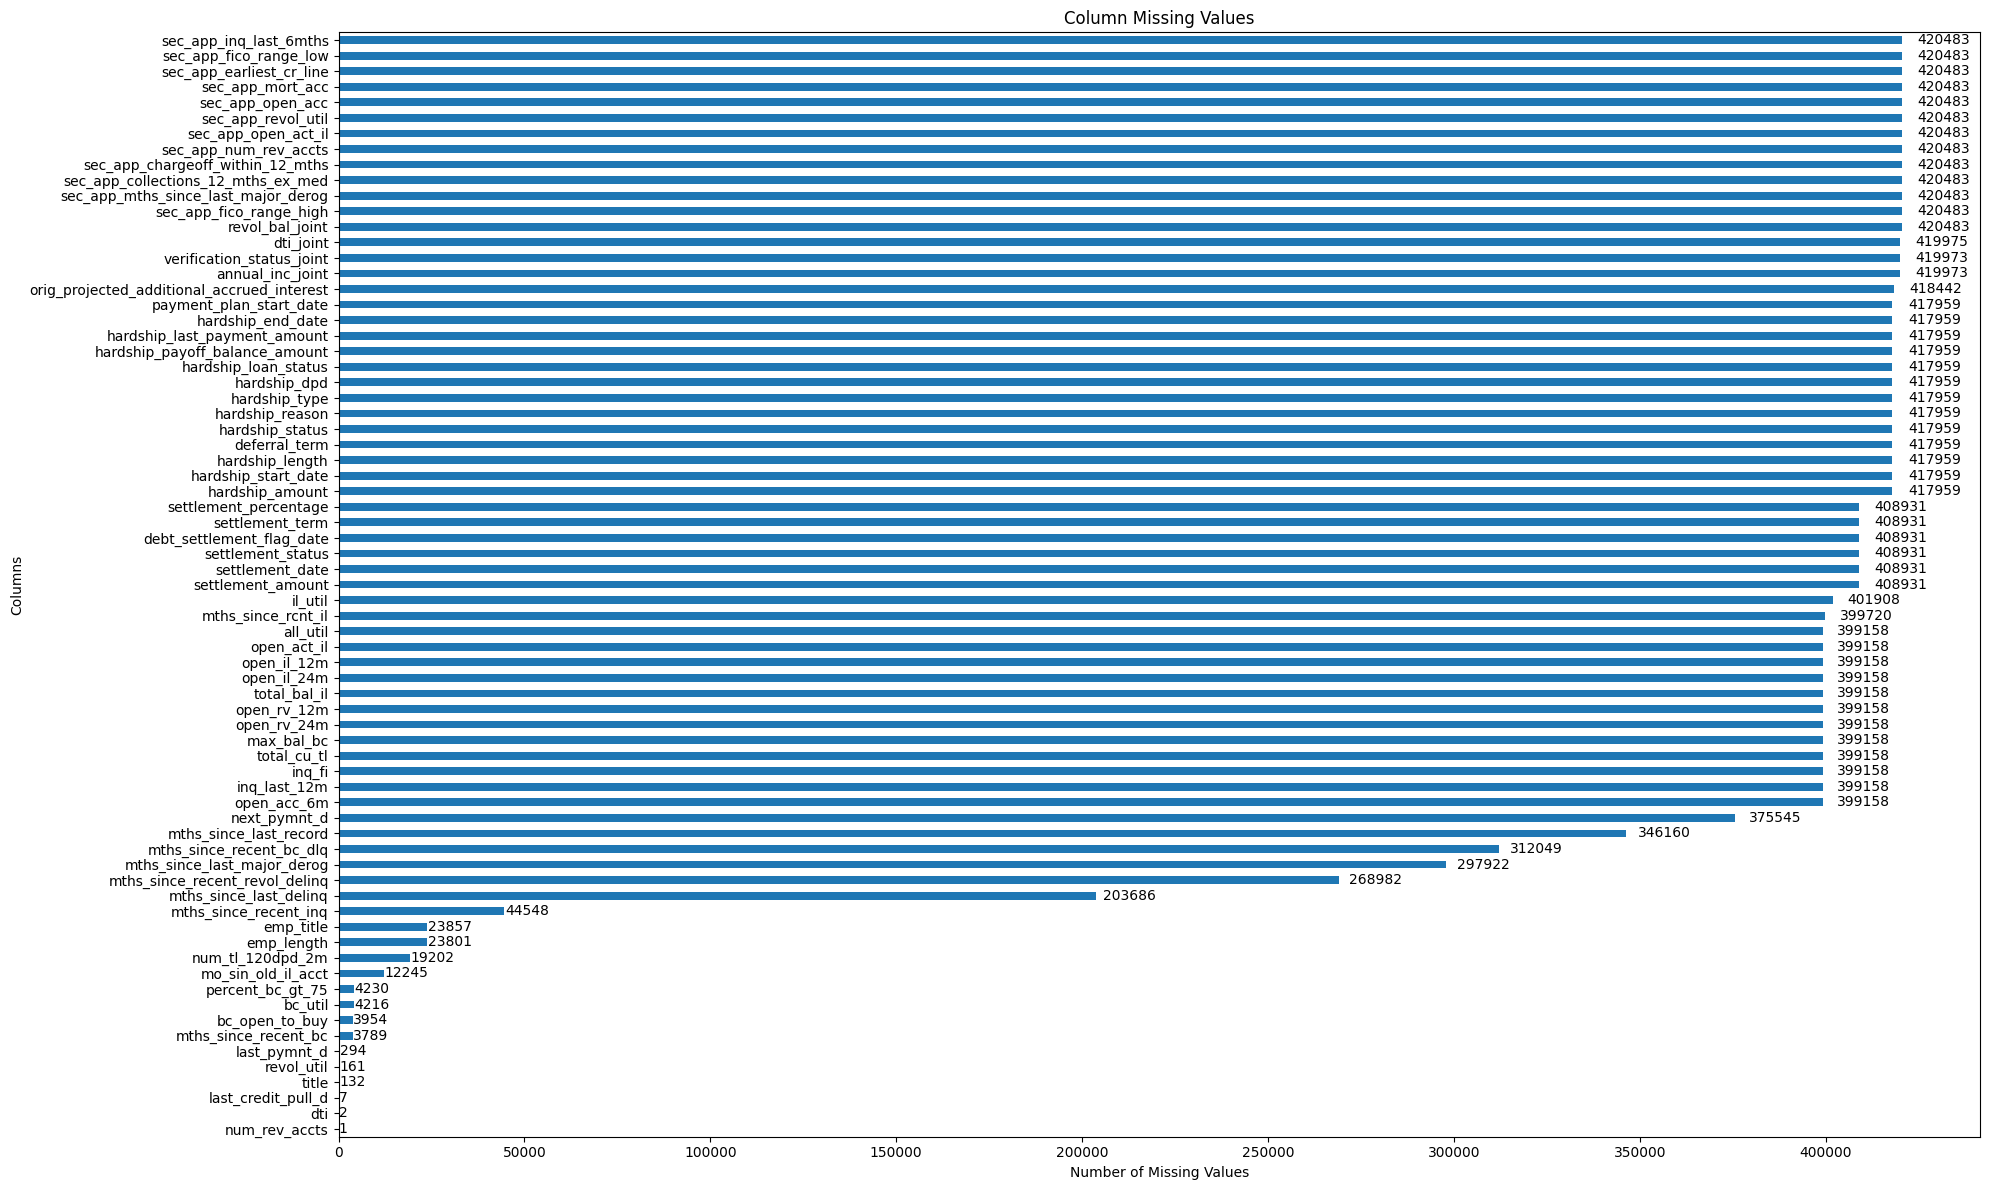

In [10]:
missing_counts_df1 = plot_missing_counts_by_columns(df1)

결측 비율 40% 초과 컬럼 정보 요약 (작업중)
___
1. 공동 대출 신청자 관련 컬럼 (4개)
    - 이 컬럼들은 대출 신청자가 한 명이 아닌 두 명 이상일 경우에만 데이터가 기록됩니다. 대부분의 대출이 단독 신청이므로 결측치가 매우 높습니다.
</br></br>
2. 2차 신청자 관련 컬럼 (12개)
    - 이 컬럼들은 sec_app_ 접두사가 붙으며, 공동 대출 신청의 2차 신청자에 대한 금융 정보를 담고 있습니다.
</br></br>
3. 채무 조정 및 부도 관련 컬럼 (20개)
- 이 컬럼들은 대출자가 재정적 어려움에 처했거나 채무 조정 프로그램을 이용했을 때만 데이터가 기록됩니다.

In [11]:
# 결측 비율 40% 초과 컬럼 정보
print(missing_counts_df1[missing_counts_df1['Missing_Ratio'] >= 40])
missing_counts_df1[missing_counts_df1['Missing_Ratio'] >= 40].shape

                                            Missing_Count  Missing_Ratio
mths_since_last_delinq                             203686      48.440960
mths_since_recent_revol_delinq                     268982      63.969768
mths_since_last_major_derog                        297922      70.852329
mths_since_recent_bc_dlq                           312049      74.212037
mths_since_last_record                             346160      82.324375
next_pymnt_d                                       375545      89.312767
open_acc_6m                                        399158      94.928451
inq_last_12m                                       399158      94.928451
inq_fi                                             399158      94.928451
total_cu_tl                                        399158      94.928451
max_bal_bc                                         399158      94.928451
open_rv_24m                                        399158      94.928451
open_rv_12m                                        

(56, 2)

1. 공동 대출 신청자 관련 컬럼 (4개)   
- annual_inc_joint: 공동 신청 시 연간 소득
- dti_joint: 공동 신청 시 부채-소득 비율
- verification_status_joint: 공동 신청 시 소득 확인 상태
- revol_bal_joint: 공동 신청 시 회전식 신용 잔고

In [12]:
# 1.공동 대출 신청자 관련 컬럼들
joint_related_columns = [col for col in missing_counts_df1.index if 'joint' in col]
display(missing_counts_df1.loc[joint_related_columns])

df1 = df1.drop(joint_related_columns, axis=1)

,Missing_Count,Missing_Ratio
annual_inc_joint,419973,99.878711
verification_status_joint,419973,99.878711
dti_joint,419975,99.879187
revol_bal_joint,420483,100.000000


2. 2차 신청자 관련 컬럼 (12개)

- sec_app_collections_12_mths_ex_med: 2차 신청자의 12개월 내 의료 제외 채권 추심 기록
- sec_app_chargeoff_within_12_mths: 2차 신청자의 12개월 내 부도 처리 기록
- sec_app_num_rev_accts: 2차 신청자의 신용 계좌 수
- sec_app_open_act_il: 2차 신청자의 할부 계좌 수
- sec_app_open_acc: 2차 신청자의 개설된 총 계좌 수
- sec_app_inq_last_6mths: 2차 신청자의 최근 6개월 내 신용 조회 수
- sec_app_mort_acc: 2차 신청자의 모기지 계좌 수
- sec_app_fico_range_high / low: 2차 신청자의 FICO 신용 점수
- sec_app_earliest_cr_line: 2차 신청자의 가장 오래된 신용 거래 기록
- sec_app_revol_util: 2차 신청자의 신용 한도 사용률
- sec_app_mths_since_last_major_derog: 2차 신청자의 마지막 주요 채무 불이행 후 경과 개월 수

In [13]:
# 2. 2차 신청자 관련 컬럼들
sec_app_related_columns = [col for col in missing_counts_df1.index if 'sec_app' in col]
display(missing_counts_df1.loc[sec_app_related_columns])

df1 = df1.drop(sec_app_related_columns, axis=1)

,Missing_Count,Missing_Ratio
sec_app_fico_range_high,420483,100.0
sec_app_mths_since_last_major_derog,420483,100.0
sec_app_collections_12_mths_ex_med,420483,100.0
sec_app_chargeoff_within_12_mths,420483,100.0
sec_app_num_rev_accts,420483,100.0
sec_app_open_act_il,420483,100.0
sec_app_revol_util,420483,100.0
sec_app_open_acc,420483,100.0
sec_app_mort_acc,420483,100.0
sec_app_earliest_cr_line,420483,100.0


3. 채무 조정 및 부도 관련 컬럼

- settlement_amount: 채무 조정 금액
- settlement_status: 채무 조정 상태
- settlement_date: 채무 조정일
- debt_settlement_flag_date: 채무 조정 플래그 설정일
- settlement_term: 채무 조정 기간
- settlement_percentage: 채무 조정된 금액의 비율
- hardship_status: 재정적 어려움 상태
- hardship_reason: 재정적 어려움 사유
- deferral_term: 상환 유예 기간
- hardship_amount: 재정적 어려움 지원 금액
- hardship_start_date / end_date: 재정적 어려움 시작/종료일
- hardship_type: 재정적 어려움 유형
- hardship_length: 재정적 어려움 기간
- hardship_last_payment_amount: 재정적 어려움 프로그램 내 마지막 상환액
- hardship_payoff_balance_amount: 재정적 어려움 프로그램 내 완납 잔액
- hardship_loan_status: 재정적 어려움 프로그램 내 대출 상태
- payment_plan_start_date: 상환 계획 시작일
- hardship_dpd: 재정적 어려움 프로그램 내 연체일 수
- orig_projected_additional_accrued_interest: 재정적 어려움 프로그램으로 인해 발생한 추가 이자

In [14]:
# 3. 채무 조정 및 부도 관련 컬럼
settlement_related_columns = [col for col in missing_counts_df1.index if 'settlement' in col]
hardship_related_columns = [col for col in missing_counts_df1.index if 'hardship' in col]

display(missing_counts_df1.loc[settlement_related_columns + hardship_related_columns])

df1 = df1.drop(settlement_related_columns + hardship_related_columns, axis=1)

,Missing_Count,Missing_Ratio
settlement_amount,408931,97.252683
settlement_date,408931,97.252683
settlement_status,408931,97.252683
debt_settlement_flag_date,408931,97.252683
settlement_term,408931,97.252683
settlement_percentage,408931,97.252683
hardship_amount,417959,99.399738
hardship_start_date,417959,99.399738
hardship_length,417959,99.399738
hardship_status,417959,99.399738


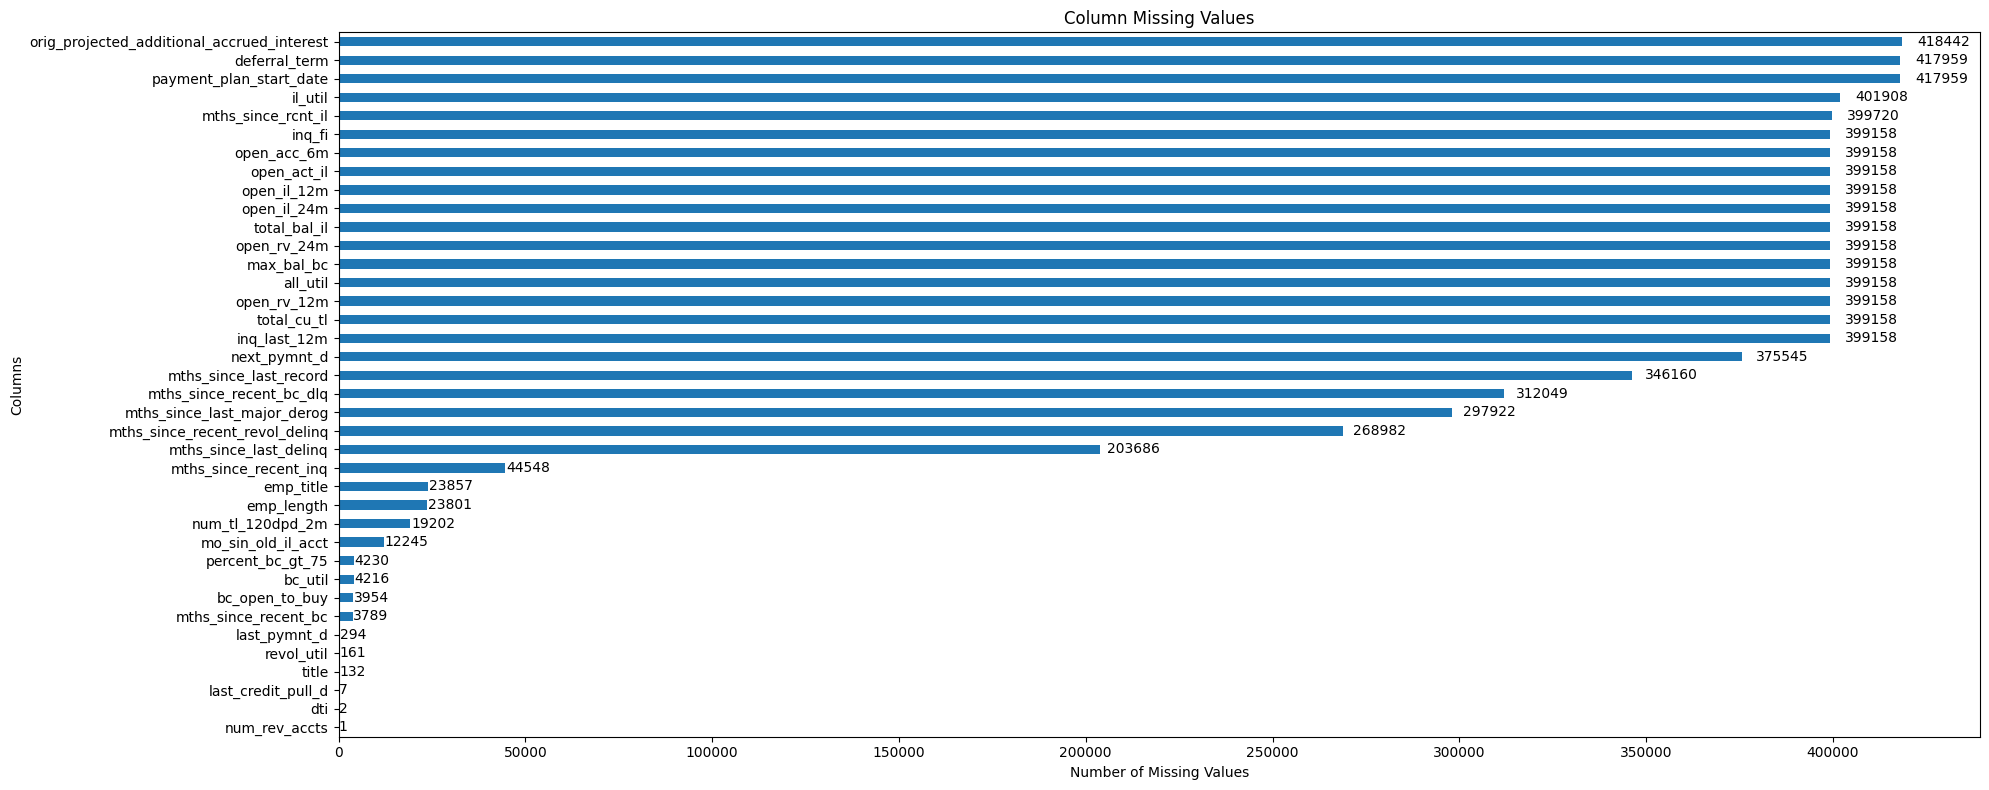

In [15]:
missing_counts_df1_rev = plot_missing_counts_by_columns(df1)

4. 신용 조회 및 계좌 관련 컬럼
___
- inq_last_12m: 최근 12개월간 신용 조회 건수.
- inq_fi: 최근 융자(mortgage/revolving 제외) 관련 조회 건수.
- open_rv_12m: 최근 12개월간 신규 회전식 계좌(신용카드 등) 개설 수.
- open_rv_24m: 최근 24개월간 신규 회전식 계좌 개설 수.
- open_il_12m: 최근 12개월간 신규 할부 계좌 개설 수.
- open_il_24m: 최근 24개월간 신규 할부 계좌 개설 수.
- open_acc_6m: 최근 6개월간 신규 신용 계좌 개설 수.
- open_act_il: 현재 개설된 할부 계좌 수.
- total_cu_tl: 신용 조합(credit union) 계좌 총 개수.
- total_bal_il: 할부 계좌(차량, 학자금 대출 등)의 총 잔액.
- mths_since_rcnt_il: 최근 할부 계좌 개설 후 경과 개월 수.
- il_util: 할부 계좌의 총 신용한도 사용률.
- all_util: 모든 신용 계좌의 총 신용한도 사용률.
- max_bal_bc: 신용카드 계좌의 최대 잔액.


In [29]:
keywords_to_filter = ['inq_', 'open_rv', 'open_il', 'open_ac', 'total_', 'il_util', 'all_util', 'max_bal_bc', 'mths_since_rcnt_il']

credit_inquiry_related_columns = [col for col in missing_counts_df1_rev.index if any(keyword in col for keyword in keywords_to_filter)]

display(missing_counts_df1.loc[credit_inquiry_related_columns])

df1 = df1.drop(credit_inquiry_related_columns, axis=1)

,Missing_Count,Missing_Ratio
inq_last_12m,399158,94.928451
total_cu_tl,399158,94.928451
open_rv_12m,399158,94.928451
all_util,399158,94.928451
max_bal_bc,399158,94.928451
open_rv_24m,399158,94.928451
total_bal_il,399158,94.928451
open_il_24m,399158,94.928451
open_il_12m,399158,94.928451
open_act_il,399158,94.928451


5. 특별 대출 프로그램 관련 컬럼
___
이 컬럼들은 대출자가 상환에 어려움을 겪어 특별 상환 계획에 참여했을 때만 기록되는 정보입니다. 

예측 모델에 포함될 경우 **데이터 누수(data leakage)**를 유발할 수 있습니다.

- payment_plan_start_date: 상환 계획이 시작된 날짜.

- deferral_term: 상환 유예 기간(개월).

- orig_projected_additional_accrued_interest: 상환 계획 변경으로 인해 추가로 발생한 예상 이자.

In [30]:
keywords_to_filter = ['payment_plan_start_date', 'deferral_term', 'orig_projected_additional_accrued_interest']

hardship_settlement_columns = [col for col in missing_counts_df1_rev.index if any(keyword in col for keyword in keywords_to_filter)]

display(missing_counts_df1.loc[hardship_settlement_columns])

df1 = df1.drop(hardship_settlement_columns, axis=1)

,Missing_Count,Missing_Ratio
payment_plan_start_date,417959,99.399738
deferral_term,417959,99.399738
orig_projected_additional_accrued_interest,418442,99.514606


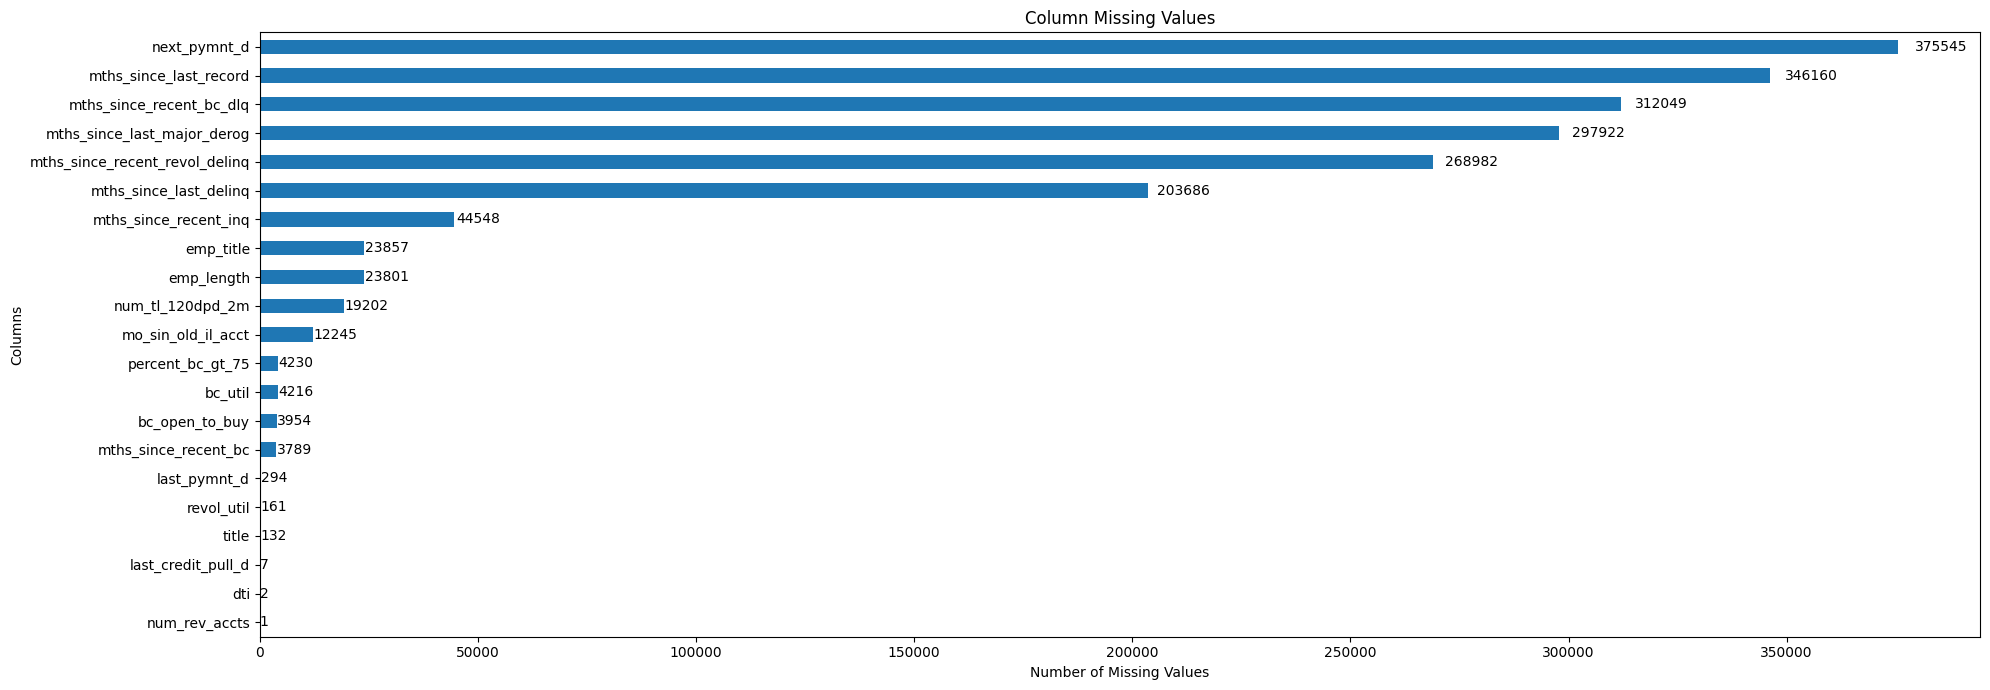

In [18]:
missing_counts_df1_rev2 = plot_missing_counts_by_columns(df1)

In [19]:
print(missing_counts_df1_rev2)

                                Missing_Count  Missing_Ratio
num_rev_accts                               1       0.000238
dti                                         2       0.000476
last_credit_pull_d                          7       0.001665
title                                     132       0.031392
revol_util                                161       0.038289
last_pymnt_d                              294       0.069920
mths_since_recent_bc                     3789       0.901107
bc_open_to_buy                           3954       0.940347
bc_util                                  4216       1.002656
percent_bc_gt_75                         4230       1.005986
mo_sin_old_il_acct                      12245       2.912127
num_tl_120dpd_2m                        19202       4.566653
emp_length                              23801       5.660395
emp_title                               23857       5.673713
mths_since_recent_inq                   44548      10.594483
mths_since_last_delinq  

6. 그외 특징들
- mths_since_last_delinq: 마지막 연체 후 경과 개월 수.
- mths_since_last_major_derog: 마지막 주요 채무 불이행 후 경과 개월 수.
- mths_since_last_record: 마지막 공개 기록(파산 등) 후 경과 개월 수.
- mths_since_recent_revol_delinq: 최근 회전식 계좌 연체 후 경과 개월 수.
- mths_since_recent_bc_dlq: 최근 신용카드 연체 후 경과 개월 수.
- next_pymnt_d: 다음 상환일.

In [31]:
keywords_to_filter = ['mths_since_la', 
                      'mths_since_recent_revol_delinq', 'mths_since_recent_bc_dlq', 'mths_since_last_record',
                      'next_pymnt_d']
etc_features = [col for col in missing_counts_df1_rev.index if any(keyword in col for keyword in keywords_to_filter)]

display(missing_counts_df1.loc[etc_features])

df1 = df1.drop(etc_features, axis=1)

,Missing_Count,Missing_Ratio
mths_since_last_delinq,203686,48.440960
mths_since_recent_revol_delinq,268982,63.969768
mths_since_last_major_derog,297922,70.852329
mths_since_recent_bc_dlq,312049,74.212037
mths_since_last_record,346160,82.324375
next_pymnt_d,375545,89.312767


In [32]:
# 신용조회 이력이 없는 데이터의 결측처리
display(missing_counts_df1.loc['mths_since_recent_inq'])

df1['mths_since_recent_inq'].fillna(999, inplace=True) 

Missing_Count    44548.000000
Missing_Ratio       10.594483
Name: mths_since_recent_inq, dtype: float64

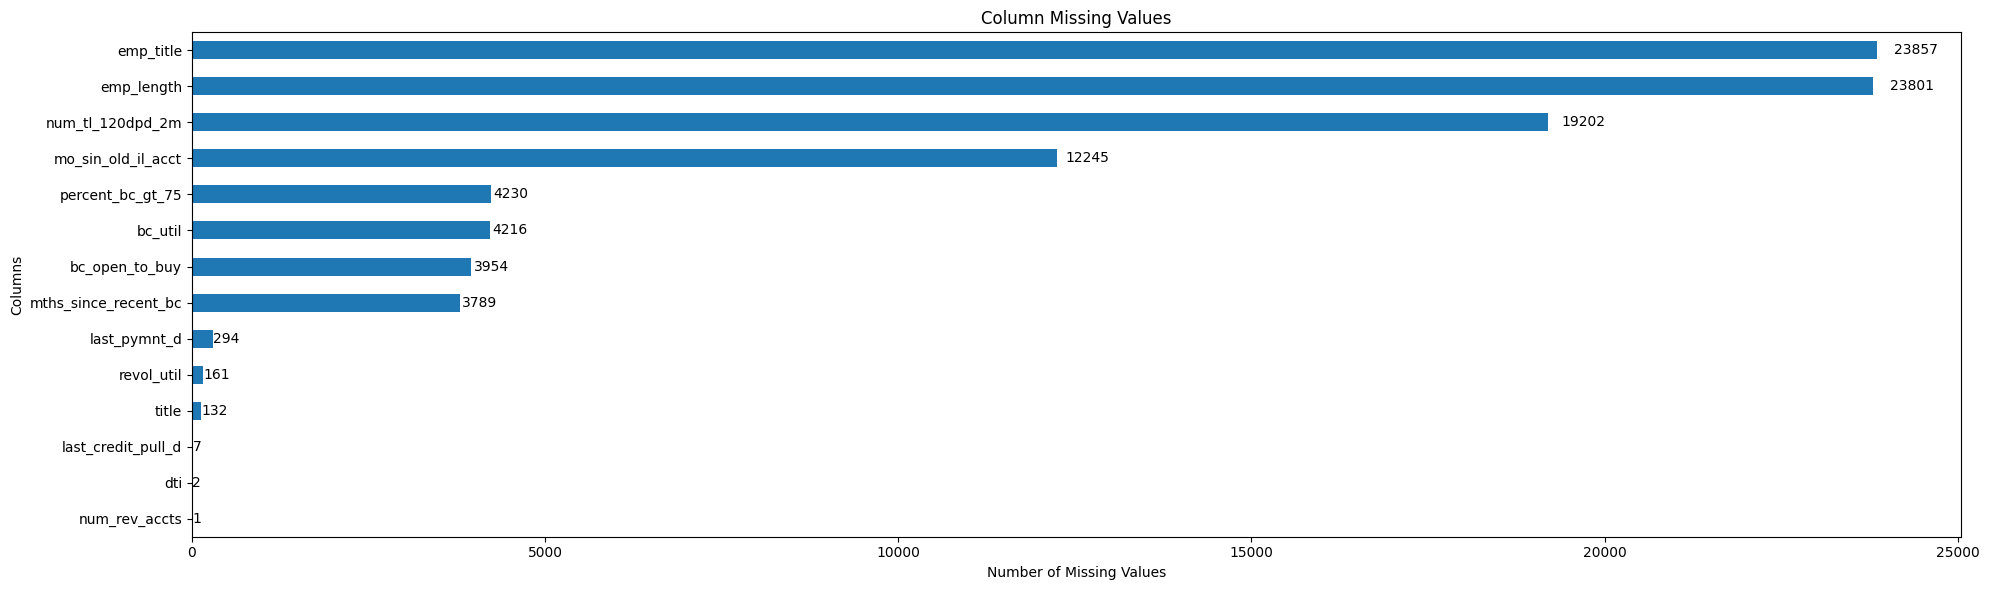

In [23]:
missing_counts_df1_rev3 = plot_missing_counts_by_columns(df1)

In [24]:
print(missing_counts_df1_rev3)

                      Missing_Count  Missing_Ratio
num_rev_accts                     1       0.000238
dti                               2       0.000476
last_credit_pull_d                7       0.001665
title                           132       0.031392
revol_util                      161       0.038289
last_pymnt_d                    294       0.069920
mths_since_recent_bc           3789       0.901107
bc_open_to_buy                 3954       0.940347
bc_util                        4216       1.002656
percent_bc_gt_75               4230       1.005986
mo_sin_old_il_acct            12245       2.912127
num_tl_120dpd_2m              19202       4.566653
emp_length                    23801       5.660395
emp_title                     23857       5.673713


7. 결측 비율이 1% 미만인 컬럼들
    - num_rev_accts: 대출자의 회전식 계좌 수.
    - dti: 부채-소득 비율.
    - revol_util: 회전식 계좌 신용 한도 사용률.

    - last_credit_pull_d: 마지막 신용 조회일.
    - title: 대출자가 기입한 대출 목적 제목.

    - revol_util: 회전식 계좌 신용 한도 사용률.
    - mths_since_recent_bc: 최근 신용카드 개설 후 경과 개월 수.
    - bc_open_to_buy: 신용카드 한도 대비 여유 금액.
    - bc_util: 신용카드 한도 사용률.
    - percent_bc_gt_75: 한도 75% 이상 사용 중인 신용카드 비율.

In [34]:
## 중앙값으로 결측 처리 
# num_rev_accts: 대출자의 회전식 계좌 수.
# dti: 부채-소득 비율.
# revol_util: 회전식 계좌 신용 한도 사용률.
display(missing_counts_df1.loc[['num_rev_accts', 'dti', 'revol_util']])

df1['num_rev_accts'] = df1['num_rev_accts'].fillna(df1['num_rev_accts'].median())
df1['dti'] = df1['dti'].fillna(df1['dti'].median())
df1['revol_util'] = df1['revol_util'].fillna(df1['revol_util'].median())

,Missing_Count,Missing_Ratio
num_rev_accts,1,0.000238
dti,2,0.000476
revol_util,161,0.038289


In [45]:
display(missing_counts_df1.loc[['last_credit_pull_d', 'title']])
# last_credit_pull_d: 마지막 신용 조회일.
# title: 대출 목적

df1['last_credit_pull_d'] = df1['last_credit_pull_d'].fillna('Jan-1900')
df1['title'] = df1['title'].fillna('None') # 대출 시 title 작성 안한 경우로 판단

,Missing_Count,Missing_Ratio
last_credit_pull_d,7,0.001665
last_pymnt_d,294,0.069920
title,132,0.031392


In [57]:
display(missing_counts_df1.loc[['mths_since_recent_bc', 'bc_open_to_buy', 'bc_util', 'percent_bc_gt_75']])
# mths_since_recent_bc: 최근 신용카드 개설 후 경과 개월 수.
# bc_open_to_buy: 신용카드 한도 대비 여유 금액.
# percent_bc_gt_75: 한도 75% 이상 사용 중인 신용카드 비율.

df1['mths_since_recent_bc'] = df1['mths_since_recent_bc'].fillna(0) # 신용카드가 없는 경우로 판단
df1['bc_open_to_buy'] = df1['bc_open_to_buy'].fillna(0) # 신용카드가 없는 경우로 판단
df1['bc_util'] = df1['bc_util'].fillna(0) # 신용카드가 없는 경우로 판단
df1['percent_bc_gt_75'] = df1['percent_bc_gt_75'].fillna(0) # 신용카드가 없는 경우로 판단

,Missing_Count,Missing_Ratio
mths_since_recent_bc,3789,0.901107
bc_open_to_buy,3954,0.940347
bc_util,4216,1.002656
percent_bc_gt_75,4230,1.005986


8. 결측 비율이 3% ~ 6% 사이인 컬럼들
    - mo_sin_old_il_acct: 가장 오래된 할부 계좌 개설 후 경과 개월 수.
    - num_tl_120dpd_2m: 최근 2년간 120일 이상 연체된 계좌 수.
    - emp_length: 현 직장 근무 기간.
    - emp_title: 직업명.

In [73]:
display(missing_counts_df1.loc[['mo_sin_old_il_acct', 'num_tl_120dpd_2m', 'emp_length', 'emp_title']])

df1['mo_sin_old_il_acct'] = df1['mo_sin_old_il_acct'].fillna(0) # 할부계좌가 없는 케이스로 판단
df1['num_tl_120dpd_2m'] = df1['num_tl_120dpd_2m'].fillna(0) # 연체되지 않은 케이스로 판단
df1['emp_title'] = df1['emp_title'].fillna('Unemployed') # 직업이 없는 케이스로 판단
df1['emp_length'] = df1['emp_length'].fillna('None') # 직업이 없는 케이스로 판단

,Missing_Count,Missing_Ratio
mo_sin_old_il_acct,12245,2.912127
num_tl_120dpd_2m,19202,4.566653
emp_length,23801,5.660395
emp_title,23857,5.673713


In [75]:
df1.isna().sum()

id                      0
loan_amnt               0
funded_amnt             0
funded_amnt_inv         0
term                    0
                       ..
debt_settlement_flag    0
issue_month             0
issue_year              0
issue_quarter           0
is_default              0
Length: 95, dtype: int64

In [76]:
#df1.to_csv('accepted_2015.csv', index = False)

## 범주형 특징 전처리

In [124]:
categorical_columns = df1.select_dtypes('object').columns 

summary_cat_features = {}
for col in categorical_columns:
  nuniq = df1[col].nunique()
  vals = df1[col].unique()
  summary_cat_features[col] = {'n_unique': nuniq, 'values': vals}

summary_cat_features = pd.DataFrame(summary_cat_features).T.sort_values('n_unique')
display(summary_cat_features)

,n_unique,values
disbursement_method,1,[Cash]
term,2,"[ 36 months, 60 months]"
debt_settlement_flag,2,"[N, Y]"
hardship_flag,2,"[N, Y]"
application_type,2,"[Individual, Joint App]"
initial_list_status,2,"[w, f]"
pymnt_plan,2,"[n, y]"
is_default,2,"[NonDefault, Default]"
verification_status,3,"[Not Verified, Source Verified, Verified]"
issue_quarter,4,"[Q4, Q3, Q2, Q1]"


In [125]:
# 삭제 대상
summary_cat_features[summary_cat_features.n_unique ==1]

,n_unique,values
disbursement_method,1,[Cash]


In [126]:
summary_cat_features[summary_cat_features.n_unique ==2]

,n_unique,values
term,2,"[ 36 months, 60 months]"
debt_settlement_flag,2,"[N, Y]"
hardship_flag,2,"[N, Y]"
application_type,2,"[Individual, Joint App]"
initial_list_status,2,"[w, f]"
pymnt_plan,2,"[n, y]"
is_default,2,"[NonDefault, Default]"


In [127]:
# pymnt_plan (상환 계획), debt_settlement_flag (채무 조정 플래그)는 데이터 누수 위험이 있으니 확인 필요

df1['hardship_flag'] = df1['hardship_flag'].map({'Y':True, 'N':False})
df1['debt_settlement_flag'] = df1['debt_settlement_flag'].map({'Y':True, 'N':False})
df1['pymnt_plan'] = df1['pymnt_plan'].map({'y':True, 'n':False})

df1['term'] = df1['term'].map({summary_cat_features.loc['term']['values'][0]:36,
                              summary_cat_features.loc['term']['values'][1]:60}).astype(int)

In [128]:
df1 = df1.drop(['disbursement_method'], axis=1) # 값 1개만 가짐

## 수치형 특징 전처리

In [150]:
tmp = df1.select_dtypes('float').describe().reset_index().T
tmp.columns = tmp.iloc[0]
tmp = tmp.drop('index')

In [155]:
tmp[(tmp['min'] <=0) & (tmp['25%'] == 0)]

index,count,mean,std,min,25%,50%,75%,max
delinq_2yrs,420483.0,0.347286,0.927472,0.0,0.0,0.0,0.0,39.0
inq_last_6mths,420483.0,0.572725,0.867802,0.0,0.0,0.0,1.0,6.0
pub_rec,420483.0,0.2338,0.649833,0.0,0.0,0.0,0.0,86.0
out_prncp,420483.0,737.511775,2352.466517,0.0,0.0,0.0,0.0,22692.22
out_prncp_inv,420483.0,737.154359,2351.220292,0.0,0.0,0.0,0.0,22692.22
total_rec_late_fee,420483.0,1.822707,12.599214,-0.0,0.0,0.0,0.0,1098.360001
recoveries,420483.0,234.565059,970.824872,0.0,0.0,0.0,0.0,35581.88
collection_recovery_fee,420483.0,41.863663,174.177807,0.0,0.0,0.0,0.0,6404.7384
collections_12_mths_ex_med,420483.0,0.020234,0.157494,0.0,0.0,0.0,0.0,14.0
acc_now_delinq,420483.0,0.006081,0.086463,0.0,0.0,0.0,0.0,14.0


분포가 오른쪽으로 치우친 특징들이 다수 식별됨. 추후 로그 변환 등 조치 필요

In [166]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420483 entries, 0 to 420482
Data columns (total 95 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          420483 non-null  int64  
 1   loan_amnt                   420483 non-null  float64
 2   funded_amnt                 420483 non-null  float64
 3   funded_amnt_inv             420483 non-null  float64
 4   term                        420483 non-null  int64  
 5   int_rate                    420483 non-null  float64
 6   installment                 420483 non-null  float64
 7   grade                       420483 non-null  object 
 8   sub_grade                   420483 non-null  object 
 9   emp_title                   396626 non-null  object 
 10  emp_length                  396682 non-null  object 
 11  home_ownership              420483 non-null  object 
 12  annual_inc                  420483 non-null  float64
 13  verification_s